In [ ]:
# Bootstrap if in colab etc
!git clone https://github.com/JWSTMassiveGalaxies/outthere-example-notebooks.git data

In [1]:
import astropy.wcs as pywcs
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
myfontsize=22
plt.rcParams.update({'font.size': myfontsize})
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,ScalarFormatter, NullFormatter,MaxNLocator, NullLocator,LogLocator
root='outthere-hudfn'
catalog_ver='v0.1'

# OutThere-HUDFN catalogs
The catalog "outthere-hudfn_redshift_v0.1.fits" contains the basic information (ID, ra, dec, magnitudes), grism redshift, $\chi^{2}_{\mathrm{reduced}}$, number of peaks of P(z) for 9558 sources with total magnitude (“AUTO”) of F200W < 26.5 AB mag for OutThere program (Program ID 3383), covering 43 arcmin$^2$ in HUDF-N. The OutThere/HUDF-N field is observed with NIRISS grism GR150C in F150W and F200W. The direct images for these bands are also available.

This iPython notebook allows the user to quickly read the catalog, select sources with high-quality spectra, and compare the grism redshifts with CANDELS catalog
 
In addition to the redshift catalog, we provide the emission line catalog ("outthere-hudfn_lines_v0.1.fits") which include emission line flux, line flux uncertatianty, rest-frame equivalent width (and its uncertainties) for each line.
 
We refer the user to "Example_Notebook_OutThere1.ipynb" for the demonstration on how one can read and plot 1D spectra, 2D spectra, emission line maps, and P(z) for individual source in the catalog. 

In [2]:
cat= Table((fits.open('%s_redshift_%s.fits' % (root, catalog_ver)   ))[1].data)
lines_cat= Table((fits.open('%s_lines_%s.fits' % (root,catalog_ver)  ))[1].data)


# Apply selection criteria
We will apply a basic selection criteria and make a histogram of grism redshifts. 
The basic selection criteria required that 
1. the contamination fraction in each band (determined from the containation in the 1D spectra and computed using the ratio of the integrated modeled contamination to the integrated flux of 1D spectra) is below 80%. 
2. The reduced $\chi^{2}_{\mathrm{red}}$ of the Grizli redshift fitting is less than 3. 
3. The number of peaks in P(z) is less than and equal to 2

The snippet code below also demonstrates on how one can select sources having the major emission lines ([OII],H$\beta$, [OIII], H$\alpha$, [S II], and S III) with high SNRs in EW (>5) and the rest-frame EWs > 20 Angstrom.





In [3]:

def compute_ngoodlines(lines_cat=None,snr_ew_thresh = 5,ew_thresh  = 20,
                       line_list = ['OII','Hb', 'OIII','Ha','SII','SIII']):
    """
    Function for counting the number of good emission lines (those lines with the SNR_EW and EW
    exceeding the thresholds 
    input:
    -- lines_cat: Astropy Table of emission lines
    -- snr_ew_thresh: minimum SNR of equivalent width 
    -- ew_thresh : # minimum rest-frame equivalent width 
    -- line_list: a list of emission lines to consider
    
    output:
    -- n_goodlines: number of emission lines satisfying condition for each object.
    """
    n_goodlines= np.zeros(len(lines_cat))
    for i in range(len(lines_cat)): 
        flags=[]
        flags.append( [1 for line in line_list if (lines_cat['%s_EQW_50' % line][i]/lines_cat['%s_EQW_1sigma' % line][i] > snr_ew_thresh)  & (lines_cat['%s_EQW_50' % line][i]>ew_thresh)   ])
        n_goodlines[i]=np.sum(flags)   
    return n_goodlines



snr_ew_thresh = 5
ew_thresh  = 20

# Counting the number of (major) emission lines that have high SNR in EW and EW > 20 Anstrom 
n_goodlines =compute_ngoodlines(lines_cat=lines_cat,snr_ew_thresh = snr_ew_thresh,ew_thresh  = ew_thresh,
                       line_list = ['OII','Hb', 'OIII','Ha','SII','SIII'])



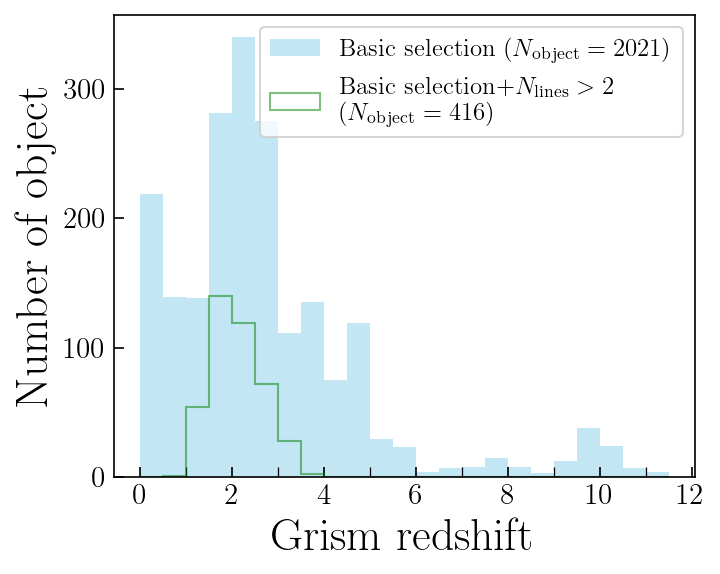

In [4]:
# Basic selection
contam_frac_thresh= 0.8 # fraction of contamination 
selection = ((cat['red_chi2']<3) 
             & (cat['contamfrac_f115w']<contam_frac_thresh) 
             & (cat['contamfrac_f150w']<contam_frac_thresh) 
             & (cat['contamfrac_f200w']<contam_frac_thresh) 
             & (cat['npeak_pz']<=2))

# Add the requirement that the object has number of good emission lines equal or more than two lines
selection_lines = selection & (n_goodlines>=2)

Nobjs = len((np.where(selection))[0])
Nobjs_lines = len((np.where(selection_lines))[0])
fig,ax= plt.subplots(figsize=(5,4),dpi=150)

zbins= np.arange(0,12,0.5)
_=ax.hist(cat['z_map'][selection], bins=zbins, color='skyblue', histtype='stepfilled',alpha=0.5,
        label=r'Basic selection ($N_{\mathrm{object}}=%d$)' % Nobjs)

_=ax.hist(cat['z_map'][selection_lines], bins=zbins, color='green', histtype='step',alpha=0.5,
        label=r'Basic selection+$N_{\mathrm{lines}}>2$'+'\n'+'($N_{\mathrm{object}}=%d$)' % Nobjs_lines)


ax.legend(loc=1,fontsize=myfontsize-10)
ax.set_xlabel('Grism redshift')
ax.set_ylabel('Number of object')
ax.tick_params(which='both',axis='both', direction='in',length=5)
ax.tick_params(axis='both', labelsize=myfontsize-8)

#ax.yaxis.set_major_locator(MultipleLocator(200))
#ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

# Read OutThere-HUDFN cross-matched with CANDELS redshift catalog.

The OutThere catalog is cross-matched with CANDELS photometric redshift catalog for GOODS-N field. The CANDELS photometric redshift catalog can be found from Version 2 Photometric redshift catalogs (Kodra et al. 2023, hlsp_candels_hst_wfc3_goodsn_multi_v2_redshift-cat.txt).


In this catalog,  the matched objects (within 1 arcsecond radius) are 4658 sources. We include all objects from outthere-hudfn_redshift_v0.1.fits. The columns taken from CANDELS catalog for an object from OutThere catalog which does not match with any CANDELS object within 1 arcsecond radius have values of -99. We provide the description on the columns of the cross-matched catalog in our README.

We will read the catalog and compare the OutThere grism redshifts and the CANDELS redshifts.


In [5]:



matched_candels_cat= Table((fits.open('%s_CANDELS_crossmatched_%s.fits' % (root,catalog_ver)  ))[1].data)
z_candels='z_best_CANDELS'
dz_1pz = (cat['z_map']-matched_candels_cat[z_candels])/(1+matched_candels_cat[z_candels])


selection_candels  = selection & (matched_candels_cat[z_candels]>0)
# Add the requirement that the object has number of good emission lines equal or more than two lines
selection_lines_candels = selection_candels & (n_goodlines>=2)

# Compute statistics for the comparison between grism redshifts and CANDELS
def statistics_compare_redshifts(selection_candels=None,z_candels='z_best_CANDELS'):
    dz_1pz = (cat['z_map']-matched_candels_cat[z_candels])/(1+matched_candels_cat[z_candels])
    sigma_nmad = 1.48* stats.median_abs_deviation(np.abs(dz_1pz[selection_candels]), scale='normal')
    outliers= (np.where(np.abs(dz_1pz[selection_candels]) >  0.15))[0]
    Noutliers = len(outliers)
    Ntot = len(dz_1pz[selection_candels])
    frac_outliers = 100*(Noutliers/Ntot)
    print('Total number of matched sources:', Ntot)
    print('Total number of outliers:',Noutliers,'(%.2f%%)' % frac_outliers)
    print('Sigma_nmad:',sigma_nmad)

    return sigma_nmad,frac_outliers
print('Apply basic selection')
sigma_nmad,frac_outliers = statistics_compare_redshifts(selection_candels=selection_candels,
                                                        z_candels=z_candels)

print('Apply basic selection and requires at least two major emission lines with SNR_EW > %d and EW> %d Angstrom' % (snr_ew_thresh,ew_thresh))
sigma_nmad_wlines,frac_outliers_wlines = statistics_compare_redshifts(selection_candels=selection_lines_candels,
                                                        z_candels=z_candels)





Apply basic selection
Total number of matched sources: 1389
Total number of outliers: 814 (58.60%)
Sigma_nmad: 0.558060583096013
Apply basic selection and requires at least two major emission lines with SNR_EW > 5 and EW> 20 Angstrom
Total number of matched sources: 333
Total number of outliers: 83 (24.92%)
Sigma_nmad: 0.045598862323089816


# Compare OutThere grism redshifts with CANDELS redshifts.
We make redshift comparison plots using a basic selection criteria and add the requirements on the number of emission lines with high SNR and high rest-frame equivalent widths.

Text(0.5, 0.98, 'Basic selection with $N_{\\mathrm{lines}}>2$')

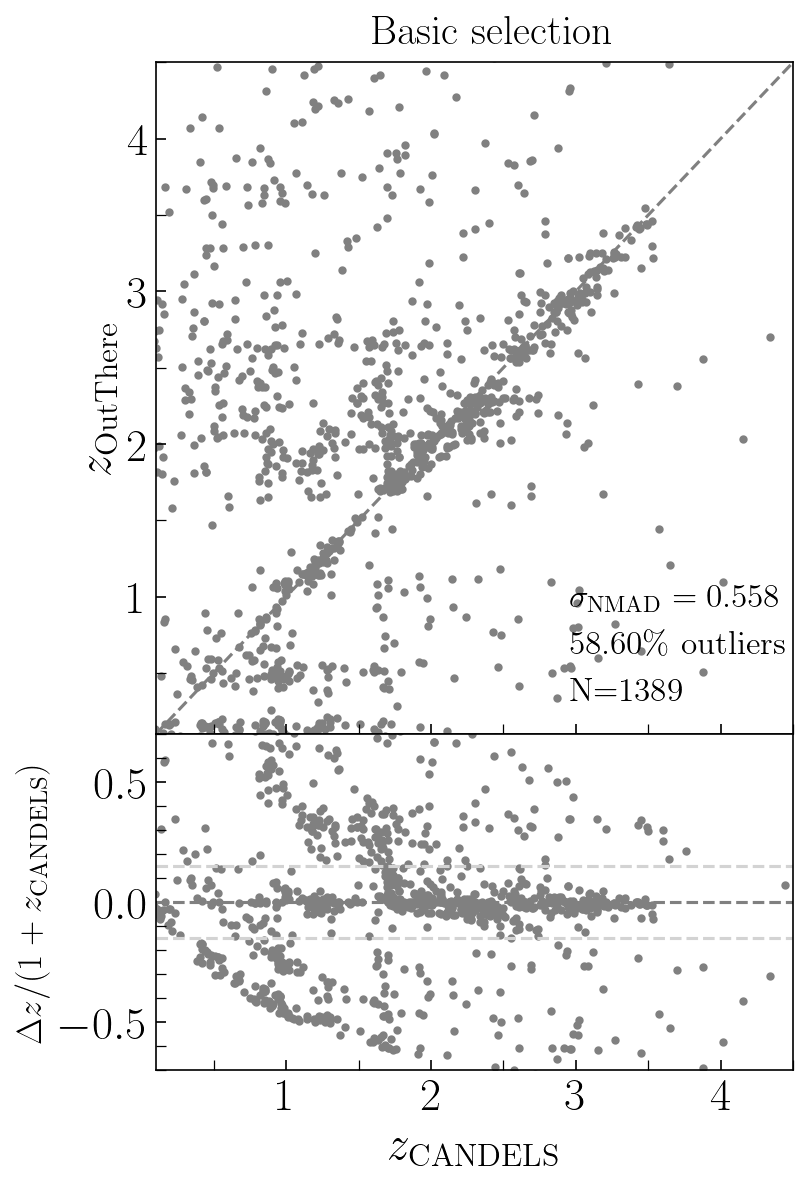

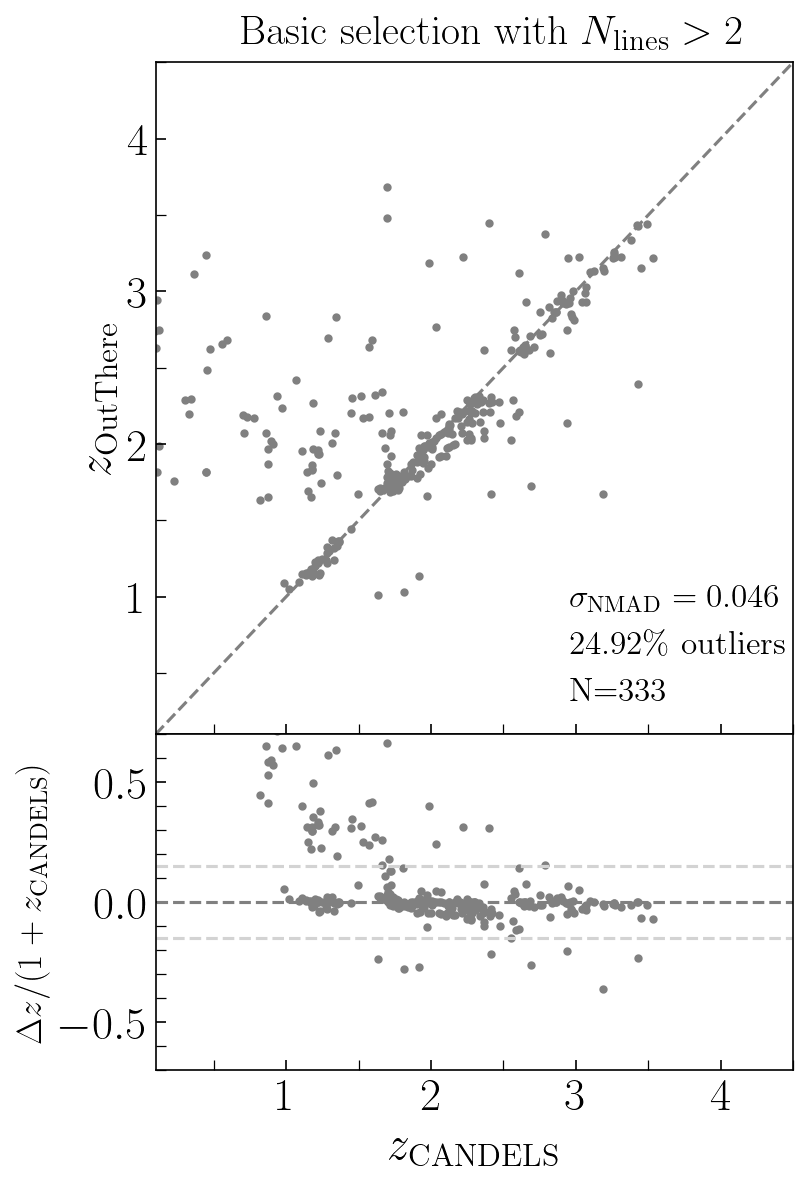

In [6]:
def create_zzplot(zmin=0.1,zmax=4.5):
    """
    # Initiate a plot for comparing redshifts.
    zmin,zmax: y-axis range
    """
    fig = plt.figure(constrained_layout=False,dpi=150,figsize=(5,8))
    width=0.43
    left=0.05
    right=0.9
    top=0.94
    bottom=0.1
    gs1 = fig.add_gridspec(nrows=3, ncols=1, left=left, right=right,top=top,bottom=bottom,
                            wspace=0.0,hspace=0)
    f_ax1 = fig.add_subplot(gs1[:-1, :])
    f_ax2 = fig.add_subplot(gs1[-1, :])
    axs=[f_ax1,f_ax2]

    axs[0].set_ylim(zmin,zmax)
    axs[0].plot([zmin,zmax],[zmin,zmax],color='grey',ls='--')
    axs[1].plot([zmin,zmax],[0,0],color='grey',ls='--')  
    axs[1].plot([zmin,zmax],[-0.15,-0.15],color='lightgrey',ls='--') 
    axs[1].plot([zmin,zmax],[0.15,0.15],color='lightgrey',ls='--') 

    axs[0].set_ylabel(r'$z_{\mathrm{OutThere}}$')
    axs[1].set_ylabel(r'$\Delta z/(1+z_{\mathrm{CANDELS}})$',fontsize=myfontsize-5)

    #    axs[1].set_ylabel(r'$\Delta z/(1+z_{\mathrm{spec}})$',fontsize=myfontsize-5)
    #axs[0].legend(fontsize=myfontsize,loc=1)
    axs[0].set_xticklabels([])
    axs[1].set_xlabel(r'$z_{\mathrm{CANDELS}}$')

    axs[1].set_ylim(-0.7,0.7)
    for i in range(len(axs)):
        axs[i].set_xlim(zmin,zmax)

        axs[i].xaxis.set_major_locator(MultipleLocator(1))
        axs[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        axs[i].tick_params(which='both',axis='both', direction='in',length=5)
        if (i==0):
            axs[i].yaxis.set_major_locator(MultipleLocator(1))
            axs[i].yaxis.set_minor_locator(MultipleLocator(0.5))
        if (i==1):
            axs[i].yaxis.set_major_locator(MultipleLocator(0.5))
            axs[i].yaxis.set_minor_locator(MultipleLocator(0.1))
    return fig,axs
fig,axs=create_zzplot(zmin=0.1,zmax=4.5)

# plot for all OutThere sources matched with CANDELS catalog (with basic selection)
axs[0].scatter(matched_candels_cat[z_candels][selection_candels], cat['z_map'][selection_candels],
               marker='.',color='grey')
axs[1].scatter(matched_candels_cat[z_candels][selection_candels],dz_1pz[selection_candels],
               marker='.',color='grey')
axs[0].text(0.65,0.19,r'$\sigma_{\mathrm{NMAD}}=%.3f$' % sigma_nmad ,
                fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.12,r'$%.2f\%%$ outliers' % frac_outliers ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.05,r'N=%d' % len(matched_candels_cat[z_candels][selection_candels]) ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
fig.suptitle('Basic selection',fontsize=myfontsize-2)


# plot for all OutThere sources matched with CANDELS catalog (with basic selection) and 
# requires at least two major emission lines with high SNRs


fig,axs=create_zzplot(zmin=0.1,zmax=4.5)

# plot for all OutThere sources matched with CANDELS catalog (with basic selection)
axs[0].scatter(matched_candels_cat[z_candels][selection_lines_candels], cat['z_map'][selection_lines_candels],
               marker='.',color='grey')
axs[1].scatter(matched_candels_cat[z_candels][selection_lines_candels],dz_1pz[selection_lines_candels],
               marker='.',color='grey')
axs[0].text(0.65,0.19,r'$\sigma_{\mathrm{NMAD}}=%.3f$' % sigma_nmad_wlines,
                fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.12,r'$%.2f\%%$ outliers' % frac_outliers_wlines ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.05,r'N=%d' % len(matched_candels_cat[z_candels][selection_lines_candels]) ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
fig.suptitle(r'Basic selection with $N_{\mathrm{lines}}>2$',fontsize=myfontsize-2)


## Applying stricter selection criteria
We also provide a wrapup function to make a redshift comparison plot for the given selection criteria
on the number of emission lines with the EWs and their SNRs exceeding some thresholds.
In the example below, we require $\chi^{2}_{\mathrm{reduced}}<3$ and snr_ew_thresh >10.


Total number of matched sources: 105
Total number of outliers: 12 (11.43%)
Sigma_nmad: 0.029500744648214536


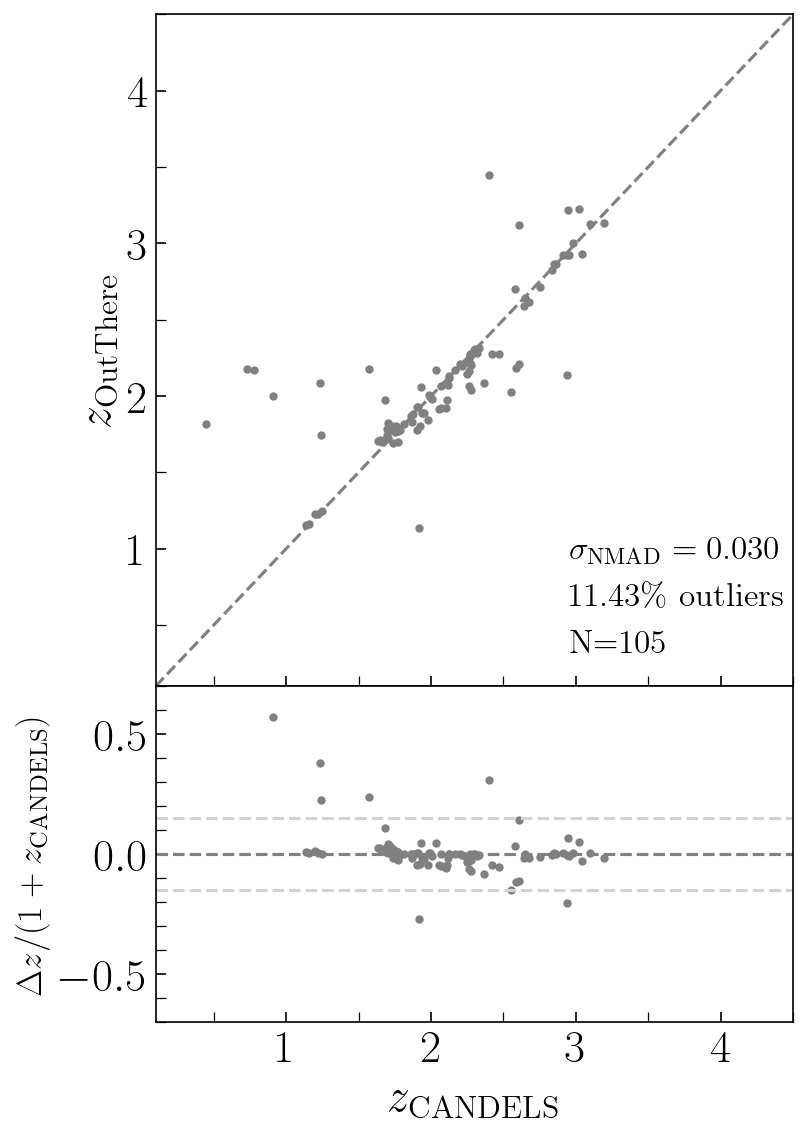

In [7]:


def compare_redshifts_plot(selection=None,selection_candels=None, 
                           snr_ew_thresh = 10, ew_thresh  = 20, nlines=2,
                           line_list=['OII','Hb', 'OIII','Ha','SII','SIII']):
    """
    selection: selection condtion for OutThere catalog to be applied before using emission lines
    selection_candels: basic selection for CANDELS
    snr_ew_thresh : threshold in SNR of EW
    ew_thresh: minimum rest-frame EW (angstrom)
    nlines: minimum number of emission lines 
    line_list: name of emission lines to consider
    """

    # Counting the number of (major) emission lines that have high SNR in EW and EW > 20 Anstrom 
    n_goodlines =compute_ngoodlines(lines_cat=lines_cat,snr_ew_thresh = snr_ew_thresh,ew_thresh  = ew_thresh,
                           line_list =line_list)


    selection_candels  = selection & (matched_candels_cat[z_candels]>0)
    # Add the requirement that the object has number of good emission lines equal or more than two lines
    selection_lines_candels = selection_candels & (n_goodlines>=nlines)

    sigma_nmad_wlines,frac_outliers_wlines = statistics_compare_redshifts(selection_candels=selection_lines_candels,
                                                            z_candels=z_candels)


    fig,axs=create_zzplot(zmin=0.1,zmax=4.5)

    # plot for all OutThere sources matched with CANDELS catalog (with basic selection)
    axs[0].scatter(matched_candels_cat[z_candels][selection_lines_candels], cat['z_map'][selection_lines_candels],
                   marker='.',color='grey')
    axs[1].scatter(matched_candels_cat[z_candels][selection_lines_candels],dz_1pz[selection_lines_candels],
                   marker='.',color='grey')
    axs[0].text(0.65,0.19,r'$\sigma_{\mathrm{NMAD}}=%.3f$' % sigma_nmad_wlines,
                    fontsize=myfontsize-6,transform=axs[0].transAxes)
    axs[0].text(0.65,0.12,r'$%.2f\%%$ outliers' % frac_outliers_wlines ,
                fontsize=myfontsize-6,transform=axs[0].transAxes)
    axs[0].text(0.65,0.05,r'N=%d' % len(matched_candels_cat[z_candels][selection_lines_candels]) ,
                fontsize=myfontsize-6,transform=axs[0].transAxes)
    #fig.suptitle(r'Basic selection with $N_{\mathrm{lines}}>2$',fontsize=myfontsize-2)

    
contam_frac_thresh= 0.8 # fraction of contamination 
selection = ((cat['red_chi2']<2)  
             & (cat['contamfrac_f115w']<contam_frac_thresh) 
             & (cat['contamfrac_f150w']<contam_frac_thresh) 
             & (cat['contamfrac_f200w']<contam_frac_thresh) 
             & (cat['npeak_pz']<=2))
selection_candels  = selection & (matched_candels_cat[z_candels]>0)
compare_redshifts_plot(selection=selection,selection_candels=selection_candels,
                       snr_ew_thresh = 10, ew_thresh  = 20, nlines=2,
                      line_list=['OII','Hb', 'OIII','Ha','SII','SIII'])